In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from utils import calc_stable_rank

data = pd.read_json('stable_rank_data.json')
data

,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7,layer 8,layer 9,layer 10,...,layer 15,layer 16,layer 17,layer 18,layer 19,layer 20,layer 21,layer 22,layer 23,layer 24
rank_Wq,37.746488,47.995172,50.518861,53.671544,45.050203,58.536675,53.638019,51.167909,50.430506,49.059962,...,29.173285,16.289259,27.153553,33.286284,15.205100,15.097324,18.034815,11.538449,7.217394,3.090915
rank_Wk,19.673634,30.292362,36.726626,42.717251,36.867566,48.009662,42.501960,41.976398,37.716193,35.964900,...,37.850995,33.648673,34.101987,33.491577,26.489028,22.502708,25.725857,20.557693,8.902950,3.921309
rank_Wv,153.928797,144.284290,196.207468,173.041136,177.458682,153.946570,162.988347,150.323667,148.750311,155.650452,...,307.226075,342.661621,361.365860,359.130686,254.066123,254.147823,249.611860,320.091048,270.543452,177.910433
rank_WqWkT,2.353477,3.058692,3.620982,4.760820,3.424343,5.645213,4.041904,4.195690,3.788177,3.765771,...,2.451966,2.057085,2.262254,2.156178,1.926153,1.923520,2.092523,1.542188,1.612376,1.460976


In [2]:
# data lists:
layer_num = [i for i in range(1,25)]
ranks_Wq = [data[layer]['rank_Wq'] for layer in data]
ranks_Wk = [data[layer]['rank_Wk'] for layer in data]
ranks_Wv = [data[layer]['rank_Wv'] for layer in data]
ranks_WqWkT = [data[layer]['rank_WqWkT'] for layer in data]

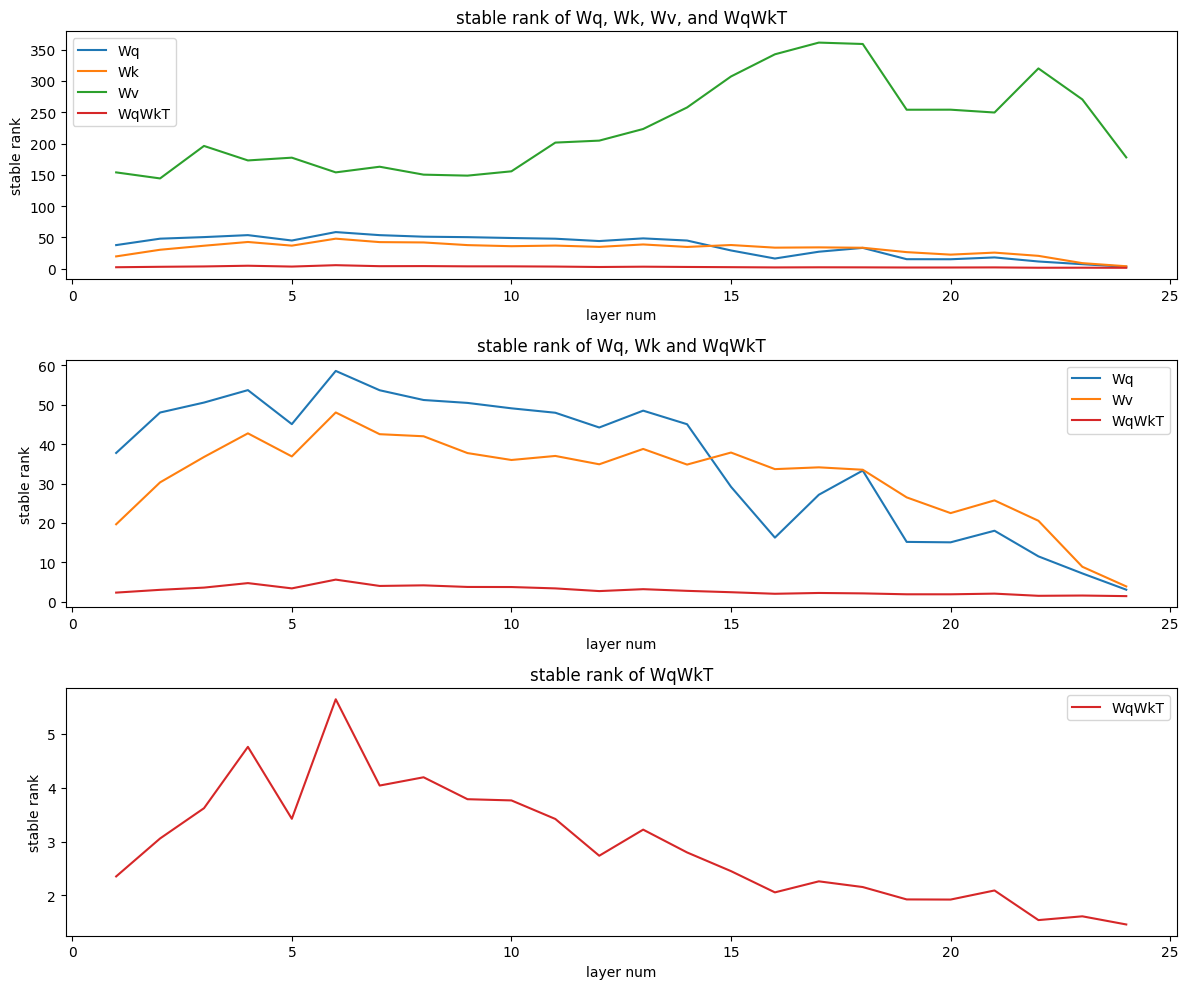

In [3]:
# plots:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,10))
blue, orange, green, red = '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'
axes[0].set(title='stable rank of Wq, Wk, Wv, and WqWkT', xlabel='layer num', ylabel='stable rank')
axes[0].plot(layer_num, ranks_Wq, label='Wq', c=blue)
axes[0].plot(layer_num, ranks_Wk, label='Wk', c=orange)
axes[0].plot(layer_num, ranks_Wv, label='Wv', c=green)
axes[0].plot(layer_num, ranks_WqWkT, label='WqWkT', c=red)
axes[0].legend()

axes[1].set(title='stable rank of Wq, Wk and WqWkT', xlabel='layer num', ylabel='stable rank')
axes[1].plot(layer_num, ranks_Wq, label='Wq', c=blue)
axes[1].plot(layer_num, ranks_Wk, label='Wv', c=orange)
axes[1].plot(layer_num, ranks_WqWkT, label='WqWkT', c=red)
axes[1].legend()

axes[2].set(title='stable rank of WqWkT', xlabel='layer num', ylabel='stable rank')
axes[2].plot(layer_num, ranks_WqWkT, label='WqWkT', c=red)
axes[2].legend()

plt.tight_layout()


In [4]:
# references:

torch.set_printoptions(edgeitems=4, sci_mode=False, linewidth=200)
rand_W = nn.Linear(2048, 2048)
# print(rand_W.weight)

random_stable_r = calc_stable_rank(rand_W.weight)
identity_W = torch.eye(2048)
identity_stable_r = calc_stable_rank(identity_W)
print(f'identity stable rank: {identity_stable_r}')
print(f'randomly init layer stable rank: {random_stable_r}')

# shows magnitude wont matter, which it shouldnt:
print(f'identity * 10 stable rank(sanity check): {calc_stable_rank(identity_W*10)}')

# try some other controls? like dot some other matricies that dont make sense just to see what happens.

# question: does WqT get same result as Wq?


identity stable rank: 2048.0
randomly init layer stable rank: 512.1538445909742
identity * 10 stable rank(sanity check): 2048.0
